In [1]:
# TensorFlow and tf.keras
# import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
import pandas as pd

import keras
from keras import layers
import keras.backend
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
import keras.models
import keras.utils


# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
import math
import time
import h5py
import sklearn
import os

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [ ]:
data = np.load('/mnt/data/ml/ShowJetsData1.npz')
for k in data.iterkeys():
    print k
# !ls /mnt/data/ml/
images = data['jetImages']
labels = data['labels']
grid = np.size(images, 1)
#ensure same number of signal vs. background and even split of z events
qcd_im = images[np.where(labels[:,0] == 1)]
if len(qcd_im) % 3 != 0:
    qcd_im = qcd_im[:len(qcd_im)-(len(qcd_im) % 3)]
z1_im = images[np.where(labels[:,1] == 1)]
z1_im = z1_im[:int(len(qcd_im)/3)]
z2_im = images[np.where(labels[:,2] == 1)]
z2_im = z2_im[:int(len(qcd_im)/3)]
z3_im = images[np.where(labels[:,3] == 1)]
z3_im = z3_im[:int(len(qcd_im)/3)]
print(len(z1_im), len(z2_im), len(z3_im), len(qcd_im))
qcd_lab = np.zeros([len(qcd_im), 2])
qcd_lab[:,0] = 1
z_lab = np.zeros([len(qcd_im), 2])
z_lab[:,1] = 1
images = np.vstack((qcd_im, z1_im, z2_im, z3_im))
labels = np.vstack((qcd_lab, z_lab))
n_data = len(images)
images = images.reshape(n_data, grid, grid, 1)
#split data into testing/training/validation

testimages = images[::4]
testlabels = labels[::4]
mask_im = np.ones(images.shape,dtype=bool)
mask_im[::4] = 0
mask_im[1::8] = 0
mask_lab = np.ones(labels.shape,dtype=bool)
mask_lab[::4] = 0
mask_lab[1::8] = 0
valimages = images[1::8]
vallabels = labels[1::8]

trainimages = images[mask_im].reshape((n_data-len(testimages)-len(valimages)), grid, grid, 1)
trainlabels = labels[mask_lab].reshape((n_data-len(testimages)-len(valimages)), 2)

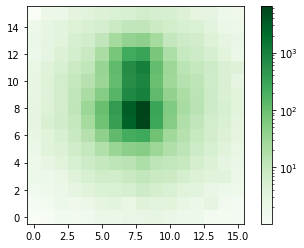

In [3]:
#plot input signal and background
sig_trainimages = np.zeros_like(trainimages[1])
bkg_trainimages = np.zeros_like(trainimages[1])
for i in range(len(trainimages)):
    if trainlabels[i,0] == 1:
        sig_trainimages += trainimages[i]
    else:
        bkg_trainimages += trainimages[i]
display_sig = sig_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_sig, interpolation='nearest', origin='low', cmap = 'Greens', norm=LogNorm())
plt.colorbar()
plt.show()

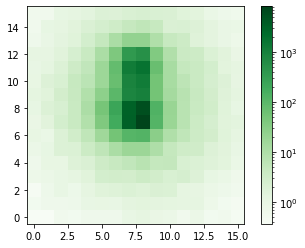

In [4]:
#background
display_bkg = bkg_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_bkg, interpolation='nearest', origin='low', cmap = 'Greens', norm=LogNorm())
plt.colorbar()
plt.show()

In [5]:
# !ls training
best_model = keras.models.load_model('model/CNN_images1.h5')
best_model.summary()
results = best_model.evaluate(testimages, testlabels)
print(results)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16, 16, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        9280      
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        147520    
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 64)        65600     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
______________________

In [6]:
predict = best_model.predict(trainimages)

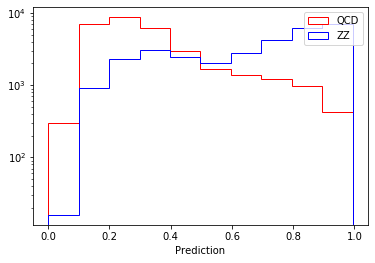

In [7]:
plt.hist([predict[np.argwhere(trainlabels[:, 1] == 1), 1], predict[np.argwhere(trainlabels[:, 1] == 0), 1]] ,
         color = ['blue', 'red'], histtype = 'step', label = ['ZZ', 'QCD'])
plt.xlabel('Prediction')
plt.yscale('log')
plt.legend()
plt.show()

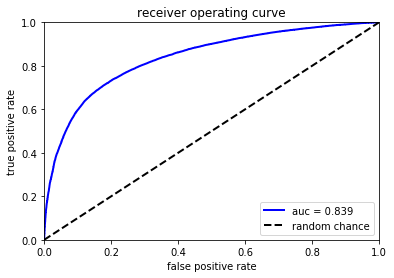

In [8]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(trainlabels[:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

In [9]:
import innvestigate
import innvestigate.utils as iutils

In [10]:
toc = time.time()

# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(best_model)
# Creating an analyzer
lrp_analyzer = innvestigate.create_analyzer("lrp.z", model_wo_softmax)
display = trainimages.reshape(len(trainimages), 1, grid, grid, 1) 
analysis = [lrp_analyzer.analyze(display[i]) for i in range(len(trainimages))]
analysis = np.concatenate(analysis, axis = 0)
tic = time.time()

print('\n time = \n', tic-toc)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

 time = 
 494.42494773864746


120
Most relevant image:


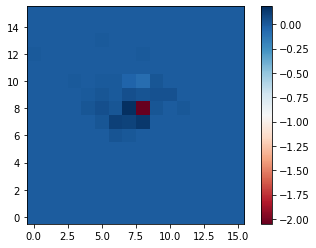

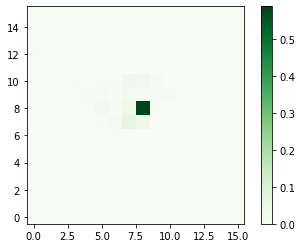

In [11]:
np.savez('model/relevance_CNN2D.npz', analysis = analysis)
rel_data = np.load('/mnt/data/ml/relevance_CNN2D.npz')
analysis = rel_data['analysis']
image_max = np.argmax(np.sum(analysis, axis = 0))
print(image_max)
print('Most relevant image:')
plt.imshow(analysis[image_max].reshape(grid, grid), cmap='RdBu', origin = 'low', interpolation='nearest')
plt.colorbar()
plt.show()
plt.imshow(trainimages[image_max].reshape(grid, grid), cmap='Greens', origin = 'low', interpolation='nearest')
plt.colorbar()
plt.show()

In [12]:
toc = time.time()
z_true = analysis[np.argwhere(trainlabels[:,1] == 1)]
z_pred = analysis[np.argwhere((trainlabels[:, 1] == 1) & (predict[:, 1] > 0.50))]
z_pred_images = trainimages[np.argwhere((trainlabels[:, 1] == 1) & (predict[:, 1] > 0.50))]
print(z_pred.shape)
z_inefficiency = analysis[np.argwhere((trainlabels[:, 1] == 1) & (predict[:, 1] < 0.50))]
qcd_true = analysis[np.argwhere(trainlabels[:,0]==1)]
qcd_pred = analysis[np.argwhere((trainlabels[:, 0] == 1) & (predict[:, 0] > 0.50))]
qcd_pred_images = trainimages[np.argwhere((trainlabels[:, 0] == 1) & (predict[:, 0] > 0.50))]
qcd_inefficiency = analysis[np.argwhere((trainlabels[:, 0] == 1) & (predict[:, 0] < 0.50))]

z_true_sum = np.sum(z_true, axis = 0)
print(z_true_sum.shape)
z_pred_sum = np.sum(z_pred, axis = 0)
z_inef_sum = np.sum(z_inefficiency, axis = 0)
qcd_true_sum = np.sum(qcd_true, axis = 0)
qcd_pred_sum = np.sum(qcd_pred, axis = 0)
qcd_inef_sum = np.sum(qcd_inefficiency, axis = 0)

#normalizing relevance scores
z_true_sum /= len(z_true)
z_pred_sum /= len(z_pred)
z_inef_sum /= len(z_inefficiency)
qcd_true_sum /= len(qcd_true)
qcd_pred_sum /= len(qcd_pred)
qcd_inef_sum /= len(qcd_inefficiency)

tic = time.time()
print('signal inefficiency = ', len(z_inefficiency)/len(z_true), '\nbackground inefficiency = ', len(qcd_inefficiency)/len(z_true))
print('\ntime =\n', tic-toc)
print('signal efficiency = ', len(z_pred)/len(z_true), '\nbackground efficiency = ', len(qcd_pred)/len(qcd_true))

(22162, 1, 16, 16, 1)
(1, 16, 16, 1)
signal inefficiency =  0.28539644665140423 
background inefficiency =  0.18224615483829362

time =
 0.43982577323913574
signal efficiency =  0.7146035533485957 
background efficiency =  0.8177479685283117


In [13]:
# set the colormap and centre the colorbar
class MidpointNormalize(Normalize):
    """Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)"""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)
        
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

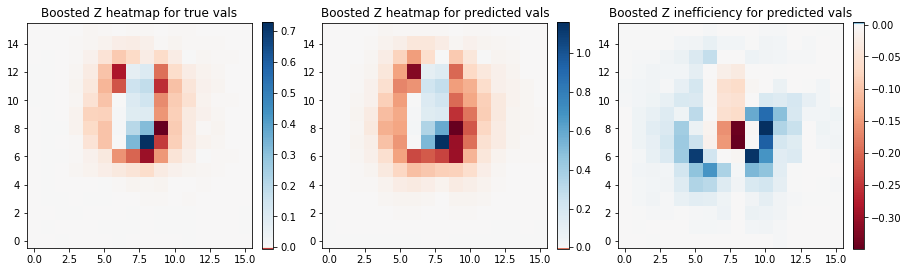

In [14]:
z_pred_max= np.max(z_pred_sum)         
z_pred_min = np.min(z_pred_sum)        
z_ineff_max= np.max(z_inef_sum)
z_ineff_min= np.min(z_inef_sum)
z_true_max= np.max(z_true_sum)
z_true_min = np.min(z_true_sum)

# Displaying the signal results
ax = plt.figure(figsize = (15,15))
ax.add_subplot(131)
im = plt.imshow(z_true_sum.reshape(grid,grid), origin = 'low',cmap='RdBu', interpolation='nearest',
                clim=(z_true_min, z_true_max), norm=MidpointNormalize(midpoint=0,vmin=z_true_min, vmax=z_true_max))
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('Boosted Z heatmap for true vals')
ax.add_subplot(132)
im = plt.imshow(z_pred_sum.reshape(grid,grid), origin = 'low', cmap='RdBu', interpolation='nearest',
                clim=(z_pred_min, z_pred_max), norm=MidpointNormalize(midpoint=0,vmin=z_pred_min, vmax=z_pred_max))
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('Boosted Z heatmap for predicted vals')
ax.add_subplot(133)
im = plt.imshow(z_inef_sum.reshape(grid,grid), origin = 'low', cmap='RdBu', interpolation='nearest',
                clim=(z_ineff_min, z_ineff_max), norm=MidpointNormalize(midpoint=0,vmin=z_ineff_min, vmax=z_ineff_max))
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('Boosted Z inefficiency for predicted vals')
plt.show()

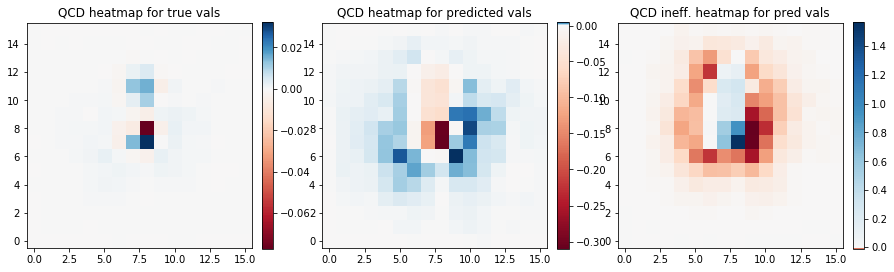

In [15]:
qcd_pred_max= np.amax(qcd_pred_sum)
qcd_pred_min = np.amin(qcd_pred_sum)
qcd_ineff_max= np.amax(qcd_inef_sum)
qcd_ineff_min= np.amin(qcd_inef_sum)
qcd_true_max= np.amax(qcd_true_sum)
qcd_true_min = np.amin(qcd_true_sum)

# Displaying the background results
ax = plt.figure(figsize = (15,15))
ax.add_subplot(131)
im_ = plt.imshow(qcd_true_sum.reshape(grid,grid), origin = 'low',cmap='RdBu', interpolation='nearest', clim=(qcd_true_min, qcd_true_max), norm=MidpointNormalize(midpoint=0,vmin=qcd_true_min, vmax=qcd_true_max))
plt.colorbar(im_,fraction=0.046, pad=0.04)
plt.title('QCD heatmap for true vals')
ax.add_subplot(132)
im_ = plt.imshow(qcd_pred_sum.reshape(grid,grid), origin = 'low',cmap='RdBu', interpolation='nearest', clim=(qcd_pred_min, qcd_pred_max), norm=MidpointNormalize(midpoint=0,vmin=qcd_pred_min, vmax=qcd_pred_max))
plt.colorbar(im_,fraction=0.046, pad=0.04)
plt.title('QCD heatmap for predicted vals')
ax.add_subplot(133)
im = plt.imshow(qcd_inef_sum.reshape(grid,grid), origin = 'low', cmap='RdBu', interpolation='nearest', clim=(qcd_ineff_min, qcd_ineff_max), norm=MidpointNormalize(midpoint=0,vmin=qcd_ineff_min, vmax=qcd_ineff_max))
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('QCD ineff. heatmap for pred vals')
plt.show()

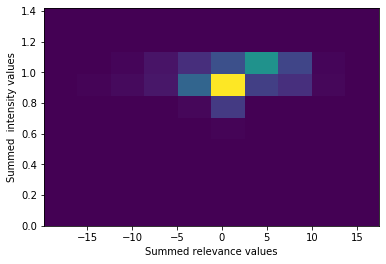

In [16]:
plt.hist2d(np.sum(analysis, axis = (-1,-2,-3)), np.sum(trainimages, axis = (-1,-2,-3)))
plt.ylabel('Summed  intensity values')
plt.xlabel('Summed relevance values')
plt.show()

In [29]:
#most significant images
z_ind = np.where(trainlabels[:,1] == 1)

1


To do:
- Plot summed pt vs. summed relevance of images
- Plot 1D histograms of predictions and summed image relevance
- Pick out "most (least) relevant" examples for qcd and zz --> check whether least relevant image has been mistagged
    - for relevant images plot pt vs. relevance of pixels
- Save analysis numpy array to file so that I don't have to rerun notebook each time
